In [1]:
import geopandas as gpd
# import osmnx as ox
import censusdata
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
year=2017
state_fips=25

In [3]:
bg=gpd.read_file('https://www2.census.gov/geo/tiger/TIGER{}/BG/tl_{}_{}_bg.zip'.format(year, year, state_fips))
# Convert to WGS84
bg = bg.to_crs("EPSG:4326")

In [4]:
bg.head()

STATEFP COUNTYFP TRACTCE BLKGRPCE         GEOID       NAMELSAD  MTFCC  \
0      25      027  730401        1  250277304011  Block Group 1  G5030   
1      25      027  730401        4  250277304014  Block Group 4  G5030   
2      25      021  422302        2  250214223022  Block Group 2  G5030   
3      25      009  203100        5  250092031005  Block Group 5  G5030   
4      25      009  217202        4  250092172024  Block Group 4  G5030   

  FUNCSTAT   ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S  360020       0  +42.3030995  -071.7835260   
1        S  342080       0  +42.2987661  -071.7733476   
2        S  345358       0  +42.1865194  -070.9418776   
3        S  363495       0  +42.4855826  -070.8801839   
4        S  576115  147631  +42.5500525  -070.9062646   

                                            geometry  
0  POLYGON ((-71.78563 42.30372, -71.78547 42.303...  
1  POLYGON ((-71.77701 42.30069, -71.77698 42.300...  
2  POLYGON ((-70.94656 42.18471, -70.94641 42.184...  
3  POLYGON ((-70.88603 42.48529, -70.88580 42.485...  
4  POLYGON ((-70.91214 42.54773, -70.91190 42.548...

# Compute example metrics over walkable community

In [ ]:
## Live-Work Symmetry
## Net-Zero Commuting
## Local Services
## Social Equity

### Load json file which maps BGs to walkable BGs

In [5]:
bg_to_walkable_bg=json.load(open('../outputs/walkable_bg/bg_to_walkable_bg_osrm_{}.json'.format(state_fips)))

### Get and clean the LODES Data

OD Files

In [6]:
import urllib.request as ur
from gzip import GzipFile
import pandas as pd

def get_od_data(state='ma'):
    req = ur.Request('https://lehd.ces.census.gov/data/lodes/LODES7/{}/od/ma_od_main_JT00_2017.csv.gz'.format(state)) 
    z_f = ur.urlopen(req)
    f = GzipFile(fileobj=z_f, mode="r")
    od = pd.read_csv(f)
    return od

def get_rac_data(state='ma'):
    req = ur.Request('https://lehd.ces.census.gov/data/lodes/LODES7/{}/rac/ma_rac_S000_JT00_2017.csv.gz'.format(state)) 
    z_f = ur.urlopen(req)
    f = GzipFile(fileobj=z_f, mode="r")
    rac = pd.read_csv(f)
    return rac

def get_wac_data(state='ma'):
    req = ur.Request('https://lehd.ces.census.gov/data/lodes/LODES7/{}/wac/ma_wac_S000_JT00_2017.csv.gz'.format(state)) 
    z_f = ur.urlopen(req)
    f = GzipFile(fileobj=z_f, mode="r")
    wac = pd.read_csv(f)
    return wac

In [7]:
# Origin-Destination (OD) File Structure
# Pos Variable Type Explanation
# 1 w_geocode Char15 Workplace Census Block Code
# 2 h_geocode Char15 Residence Census Block Code
# 3 S000 Num Total number of jobs
# 4 SA01 Num Number of jobs of workers age 29 or younger16
# 5 SA02 Num Number of jobs for workers age 30 to 5416
# 6 SA03 Num Number of jobs for workers age 55 or older16
# 7 SE01 Num Number of jobs with earnings $1250/month or less
# 8 SE02 Num Number of jobs with earnings $1251/month to $3333/month
# 9 SE03 Num Number of jobs with earnings greater than $3333/month
# 10 SI01 Num Number of jobs in Goods Producing industry sectors
# 11 SI02 Num Number of jobs in Trade, Transportation, and Utilities industry sectors
# 12 SI03 Num Number of jobs in All Other Services industry sectors
# 13 createdate Char Date on which data was created, formatted as YYYYMMDD 

In [8]:
od=get_od_data(state='ma')
# block -> block group
od['w_block_group']=od.apply(lambda row: str(row['w_geocode'])[0:12], axis=1)
od['h_block_group']=od.apply(lambda row: str(row['h_geocode'])[0:12], axis=1)
cols_to_sum=['S000', 'SA01', 'SA02', 'SA03', 'SE01','SE02', 'SE03', 'SI01', 'SI02', 'SI03']


In [9]:
# For easy indexing save two copies of the OD matrix df
od_by_hbg_wbg=od.groupby(['h_block_group', 'w_block_group'] , as_index=True)[cols_to_sum].agg('sum')
od_by_wbg_hbg=od.groupby(['w_block_group', 'h_block_group'] , as_index=True)[cols_to_sum].agg('sum')
# also repeat the work bg as a column for doing a secondary indexing (see below)
od_by_hbg_wbg['w_block_group']=od_by_hbg_wbg.apply(lambda row: row.name[1], axis=1)

In [10]:
od_by_hbg_wbg.head()

S000  SA01  SA02  SA03  SE01  SE02  SE03  SI01  \
h_block_group w_block_group                                                   
250010101001  250010101001     30     5    13    12     7    11    12     0   
              250010101002     12     4     4     4     2     7     3     1   
              250010101003     36     3    19    14     7    22     7     0   
              250010101004     62     4    35    23    12    18    32     7   
              250010101005     80    13    35    32    21    37    22     0   

                             SI02  SI03 w_block_group  
h_block_group w_block_group                            
250010101001  250010101001     15    15  250010101001  
              250010101002      1    10  250010101002  
              250010101003      8    28  250010101003  
              250010101004     10    45  250010101004  
              250010101005      8    72  250010101005

In [11]:
od_by_wbg_hbg.head()

S000  SA01  SA02  SA03  SE01  SE02  SE03  SI01  \
w_block_group h_block_group                                                   
250010101001  250010101001     30     5    13    12     7    11    12     0   
              250010101002     18     3     9     6     3     9     6     0   
              250010101003     35     6    13    16     7    10    18     1   
              250010101004     37     5    25     7     6    19    12     0   
              250010101005     23     1    13     9     7     6    10     0   

                             SI02  SI03  
w_block_group h_block_group              
250010101001  250010101001     15    15  
              250010101002      6    12  
              250010101003     16    18  
              250010101004     19    18  
              250010101005      9    14

RAC and WAC fles

In [12]:
rac=get_rac_data(state='ma')
wac=get_wac_data(state='ma')

#### Both files:
- CA: age groups
- CE: earnings groups
- CNS: NAICS
- CR: race
- CT: ethnicity
- CD: education
- CS: sex
#### Additional in WAC:
- CFA: firm age
- CFA: firm size

In [13]:
rac_cols_to_sum=[col for col in rac.columns if not col in ['h_geocode', 'createdate']]
rac['h_block_group']=rac.apply(lambda row: str(row['h_geocode'])[0:12], axis=1)
rac_bg=rac.groupby('h_block_group', as_index=True)[rac_cols_to_sum].agg('sum')
rac_bg.head()

C000  CA01  CA02  CA03  CE01  CE02  CE03  CNS01  CNS02  CNS03  \
h_block_group                                                                  
250010101001    374    59   172   143    93   133   148      2      0      0   
250010101002    248    43   126    79    71    83    94      0      0      0   
250010101003    297    46   138   113    67   110   120      0      0      0   
250010101004    302    54   148   100    96   113    93      0      0      0   
250010101005    297    34   162   101    81   106   110      0      0      0   

               ...  CR05  CR07  CT01  CT02  CD01  CD02  CD03  CD04  CS01  CS02  
h_block_group  ...                                                              
250010101001   ...     0     9   354    20    32    74    99   110   213   161  
250010101002   ...     1     2   239     9    13    58    59    75   140   108  
250010101003   ...     0     6   277    20    35    71    77    68   171   126  
250010101004   ...     1     4   278    24    27    60    96    65   152   150  
250010101005   ...     0     7   276    21    37    67    82    77   150   147  

[5 rows x 41 columns]

In [14]:
wac_cols_to_sum=[col for col in wac.columns if not col in ['w_geocode', 'createdate']]
wac['w_block_group']=wac.apply(lambda row: str(row['w_geocode'])[0:12], axis=1)
wac_bg=wac.groupby('w_block_group', as_index=True)[wac_cols_to_sum].agg('sum')
wac_bg.head()

C000  CA01  CA02  CA03  CE01  CE02  CE03  CNS01  CNS02  CNS03  \
w_block_group                                                                  
250010101001    312    67   152    93    62   132   118      0      0      0   
250010101002    100    22    46    32    22    31    47      3      0      0   
250010101003    253    28   123   102    44   116    93      1      0      0   
250010101004    586    73   296   217   154   232   200      2      0      0   
250010101005    645    98   341   206   165   234   246      3      0      0   

               ...  CFA01  CFA02  CFA03  CFA04  CFA05  CFS01  CFS02  CFS03  \
w_block_group  ...                                                           
250010101001   ...      0      0      0      0      0      0      0      0   
250010101002   ...      0      0      0      0      0      0      0      0   
250010101003   ...      0      0      0      0      0      0      0      0   
250010101004   ...      0      0      0      0      0      0      0      0   
250010101005   ...      0      0      0      0      0      0      0      0   

               CFS04  CFS05  
w_block_group                
250010101001       0      0  
250010101002       0      0  
250010101003       0      0  
250010101004       0      0  
250010101005       0      0  

[5 rows x 51 columns]

In [15]:
all_bg_in_rac=set(rac_bg.index)
all_bg_in_wac=set(wac_bg.index)

### Functions to compute metrics for a single GEOID

#### Basic Statistics

In [16]:
def get_residents_columns_rac(bgs_in_community, full_rac, all_bg_in_rac):
    """
    returns a subset of the OD matrix
    The subset includes all rows corresponding to origins within the community
    i.e. all residents of the community
    """
    output_dict={}
    bgs_in_rac=[bg for bg in bgs_in_community if bg in all_bg_in_rac]
    if len(bgs_in_rac)>0:
        rac_subset=full_rac.loc[bgs_in_rac]
        sum_rac=rac_subset.sum()
        output_dict['total_pop_rac']=sum_rac['C000']
        output_dict['res_income_u1250_rac']=sum_rac['CE01']
        output_dict['res_income_1251-3333_rac']=sum_rac['CE02']
        output_dict['res_income_3333+_rac']=sum_rac['CE03']
        output_dict['res_age_u29_rac']=sum_rac['CE01']
        output_dict['res_age_30-54_rac']=sum_rac['CE02']
        output_dict['res_age_55+_rac']=sum_rac['CE03']
        output_dict['res_edu_no_highsch']=sum_rac['CD01']
        output_dict['res_edu_highsch']=sum_rac['CD02']
        output_dict['res_edu_some_college']=sum_rac['CD03']
        output_dict['res_edu_bach_or_higher']=sum_rac['CD04']
    else:
        print('No data for this community in RAC file: {}'.format(bgs_in_community))
    return output_dict


In [17]:
def get_workers_columns_wac(bgs_in_community, full_wac, all_bg_in_wac):
    """
    returns a subset of the OD matrix
    The subset includes all rows corresponding to origins within the community
    i.e. all residents of the community
    """
    output_dict={}
    bgs_in_wac=[bg for bg in bgs_in_community if bg in all_bg_in_wac]
    if len(bgs_in_wac)>0:
        wac_subset=full_wac.loc[bgs_in_wac]
        sum_wac=wac_subset.sum()
        output_dict['total_employ_wac']=sum_wac['C000']
        output_dict['emp_income_u1250_wac']=sum_wac['CE01']
        output_dict['emp_income_1251-3333_wac']=sum_wac['CE02']
        output_dict['emp_income_3333+_wac']=sum_wac['CE03']
        output_dict['emp_age_u29_wac']=sum_wac['CE01']
        output_dict['emp_age_30-54_wac']=sum_wac['CE02']
        output_dict['emp_age_55+_wac']=sum_wac['CE03']
        output_dict['emp_edu_no_highsch']=sum_wac['CD01']
        output_dict['emp_edu_highsch']=sum_wac['CD02']
        output_dict['emp_edu_some_college']=sum_wac['CD03']
        output_dict['emp_edu_bach_or_higher']=sum_wac['CD04']
        output_dict['emp_naics_11']=sum_wac['CNS01']
        output_dict['emp_naics_21']=sum_wac['CNS02']
        output_dict['emp_naics_22']=sum_wac['CNS03']
        output_dict['emp_naics_23']=sum_wac['CNS04']
        output_dict['emp_naics_31-33']=sum_wac['CNS05']
        output_dict['emp_naics_42']=sum_wac['CNS06']
        output_dict['emp_naics_44-45']=sum_wac['CNS07']
        output_dict['emp_naics_48-49']=sum_wac['CNS08']
        output_dict['emp_naics_51']=sum_wac['CNS09']
        output_dict['emp_naics_52']=sum_wac['CNS10']
        output_dict['emp_naics_53']=sum_wac['CNS11']
        output_dict['emp_naics_54']=sum_wac['CNS12']
        output_dict['emp_naics_55']=sum_wac['CNS13']
        output_dict['emp_naics_56']=sum_wac['CNS14']
        output_dict['emp_naics_61']=sum_wac['CNS15']
        output_dict['emp_naics_62']=sum_wac['CNS16']
        output_dict['emp_naics_71']=sum_wac['CNS17']
        output_dict['emp_naics_72']=sum_wac['CNS18']
        output_dict['emp_naics_81']=sum_wac['CNS19']
        output_dict['emp_naics_92']=sum_wac['CNS20']
        output_dict['emp_prv_firm_size_u19']=sum_wac['CFS01']
        output_dict['emp_prv_firm_size_20-49']=sum_wac['CFS02']
        output_dict['emp_prv_firm_size_50-249']=sum_wac['CFS03']
        output_dict['emp_prv_firm_size_250-499']=sum_wac['CFS04']
        output_dict['emp_prv_firm_size_500+']=sum_wac['CFS05']
        output_dict['emp_prv_firm_age_0-1']=sum_wac['CFA01']
        output_dict['emp_prv_firm_age_2-3']=sum_wac['CFA02']
        output_dict['emp_prv_firm_age_4-5']=sum_wac['CFA03']
        output_dict['emp_prv_firm_age_6-10']=sum_wac['CFA04']
        output_dict['emp_prv_firm_age_11+']=sum_wac['CFA05']
    else:
        print('No data for this community in WAC file: {}'.format(bgs_in_community))
    return output_dict

In [18]:
def get_live_and_work_columns(bgs_in_community, od_by_hbg_wbg, all_bg_in_rac):
    output_dict={}
    bgs_in_od=[bg for bg in bgs_in_community if bg in all_bg_in_wac]
    if len(bgs_in_od)>0:
        live_community=od_by_hbg_wbg.loc[bgs_in_od]
        live_work_community=live_community.loc[live_community['w_block_group'].isin(bgs_in_community)]
        sum_live_work_community=live_work_community.sum()
        output_dict['total_live_and_work_od']=sum_live_work_community['S000']
    else:
        print('No data for this community in OD file: {}'.format(bgs_in_community))
    return output_dict  

In [19]:
def get_lodes_stats(row):
    geoid=row['GEOID']
    bgs_in_community=bg_to_walkable_bg[geoid]
#     print('{}: {}'.format(geoid, bgs_in_community))
    wac_outputs=get_workers_columns_wac(bgs_in_community, full_wac=wac_bg, all_bg_in_wac=all_bg_in_wac)
    rac_outputs=get_residents_columns_rac(bgs_in_community, full_rac=rac_bg, all_bg_in_rac=all_bg_in_rac)
#     od_outputs=get_live_and_work_columns(bgs_in_community, od_by_hbg_wbg, all_bg_in_rac=all_bg_in_rac)
    for var in rac_outputs:
        row[var]=rac_outputs[var]
    for var in wac_outputs:
        row[var]=wac_outputs[var]
#     for var in od_outputs:
#         row[var]=od_outputs[var]
    return row

In [20]:
bg=bg.apply(lambda row: get_lodes_stats(row), axis=1)

No data for this community in WAC file: ['250259901010']
No data for this community in RAC file: ['250259901010']
No data for this community in WAC file: ['250239900030']
No data for this community in RAC file: ['250239900030']
No data for this community in WAC file: ['250056171015']
No data for this community in RAC file: ['250056171015']
No data for this community in WAC file: ['250199900000']
No data for this community in RAC file: ['250199900000']
No data for this community in WAC file: ['250019900000']
No data for this community in RAC file: ['250019900000']
No data for this community in WAC file: ['250158219032']
No data for this community in RAC file: ['250138113021']
No data for this community in WAC file: ['250079900000']
No data for this community in RAC file: ['250079900000']
No data for this community in WAC file: ['250259801011']
No data for this community in WAC file: ['250059900000']
No data for this community in RAC file: ['250059900000']
No data for this community in W

In [21]:
bg.head()

ALAND  AWATER BLKGRPCE COUNTYFP FUNCSTAT         GEOID     INTPTLAT  \
0  360020       0        1      027        S  250277304011  +42.3030995   
1  342080       0        4      027        S  250277304014  +42.2987661   
2  345358       0        2      021        S  250214223022  +42.1865194   
3  363495       0        5      009        S  250092031005  +42.4855826   
4  576115  147631        4      009        S  250092172024  +42.5500525   

       INTPTLON  MTFCC       NAMELSAD  ... res_age_u29_rac  \
0  -071.7835260  G5030  Block Group 1  ...           185.0   
1  -071.7733476  G5030  Block Group 4  ...           404.0   
2  -070.9418776  G5030  Block Group 2  ...           129.0   
3  -070.8801839  G5030  Block Group 5  ...           330.0   
4  -070.9062646  G5030  Block Group 4  ...           265.0   

  res_edu_bach_or_higher  res_edu_highsch  res_edu_no_highsch  \
0                  254.0            158.0                60.0   
1                  336.0            295.0               205.0   
2                  168.0             94.0                43.0   
3                  645.0            274.0               100.0   
4                  462.0            206.0                88.0   

   res_edu_some_college  res_income_1251-3333_rac  res_income_3333+_rac  \
0                 195.0                     272.0                 425.0   
1                 358.0                     627.0                 594.0   
2                 121.0                     103.0                 327.0   
3                 428.0                     287.0                1090.0   
4                 340.0                     285.0                 808.0   

   res_income_u1250_rac  total_employ_wac  total_pop_rac  
0                 185.0              42.0          882.0  
1                 404.0             479.0         1625.0  
2                 129.0               9.0          559.0  
3                 330.0             539.0         1707.0  
4                 265.0             125.0         1358.0  

[5 rows x 65 columns]

### Live-Work Balance Score

In [22]:
def get_live_work_score(row):
    if row['total_pop_rac'] > row['total_employ_wac']:
        return row['total_employ_wac']/row['total_pop_rac']
    else:
        return row['total_pop_rac']/row['total_employ_wac']
    
# TODO- fix function to get live_work data before the below function
def get_live_work_jaccard_score(row):
    return None

In [23]:
bg['live_work_score']=bg.apply(lambda row: get_live_work_score(row), axis=1)

Text(0.5, 1.0, 'Live-Work Score')

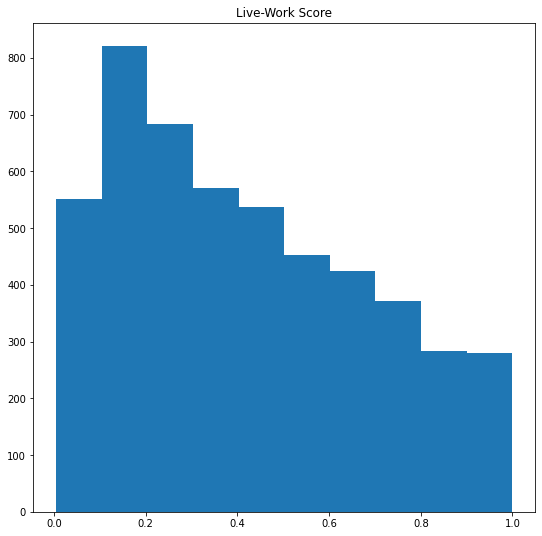

In [24]:
plt.figure(figsize=(9,9))
_=plt.hist(bg['live_work_score'])
plt.title('Live-Work Score')

<AxesSubplot:>

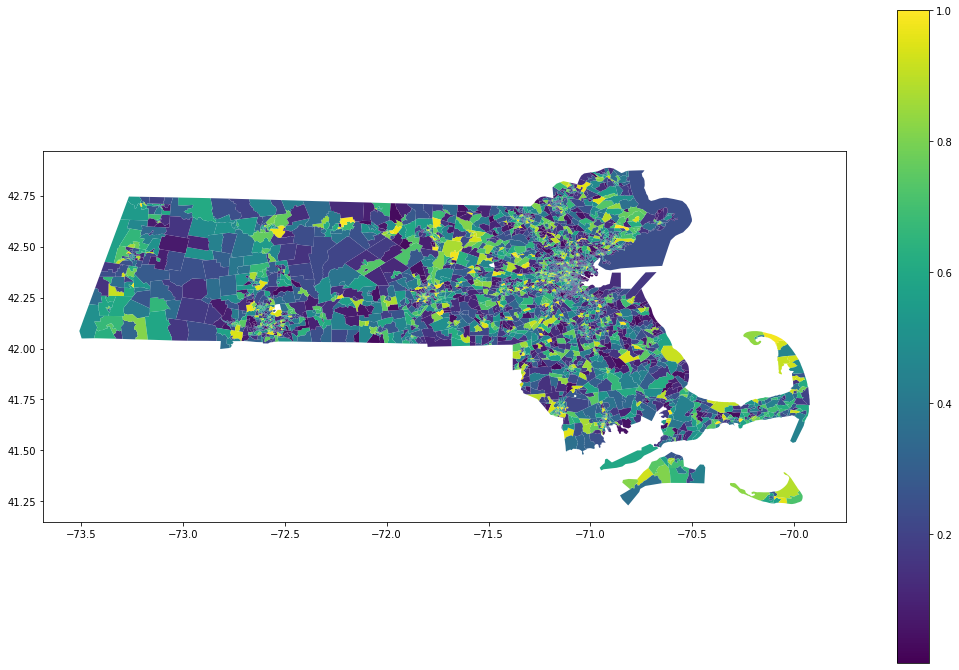

In [25]:
fig, ax=plt.subplots(1, figsize=(18,12))
bg.plot(ax=ax,
        column='live_work_score',
        legend=True)

### Demographic Harmony Scores

In [26]:
from numpy import dot
from numpy.linalg import norm

def get_income_harmony(row):
    res_income_vec=row.loc[['res_income_1251-3333_rac', 'res_income_3333+_rac', 'res_income_u1250_rac']]
    emp_income_vec=row.loc[['emp_income_1251-3333_wac', 'emp_income_3333+_wac', 'emp_income_u1250_wac']]
    a, b = res_income_vec.values, emp_income_vec.values
    return dot(a,b)/(norm(a)*norm(b))  

def get_edu_harmony(row):
    res_edu_vec=row[['res_edu_no_highsch', 'res_edu_highsch', 'res_edu_some_college', 'res_edu_bach_or_higher']]
    emp_edu_vec=row[['emp_edu_no_highsch', 'emp_edu_highsch', 'emp_edu_some_college', 'emp_edu_bach_or_higher']]
    a, b = res_edu_vec.values, emp_edu_vec.values
    return dot(a,b)/(norm(a)*norm(b)) 

In [27]:
# for col in bg.columns:
#     if 'edu' in col:
#         print(col)

In [28]:
bg['income_harmony']=bg.apply(lambda row: get_income_harmony(row), axis=1)
bg['edu_harmony']=bg.apply(lambda row: get_edu_harmony(row), axis=1)

<ipython-input-26-e59151ec7764>:14: RuntimeWarning: invalid value encountered in double_scalars
  return dot(a,b)/(norm(a)*norm(b))


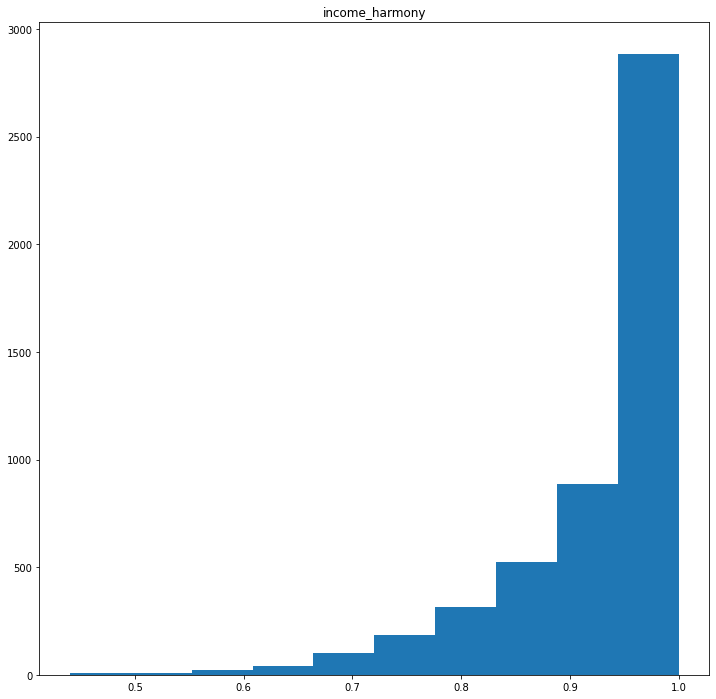

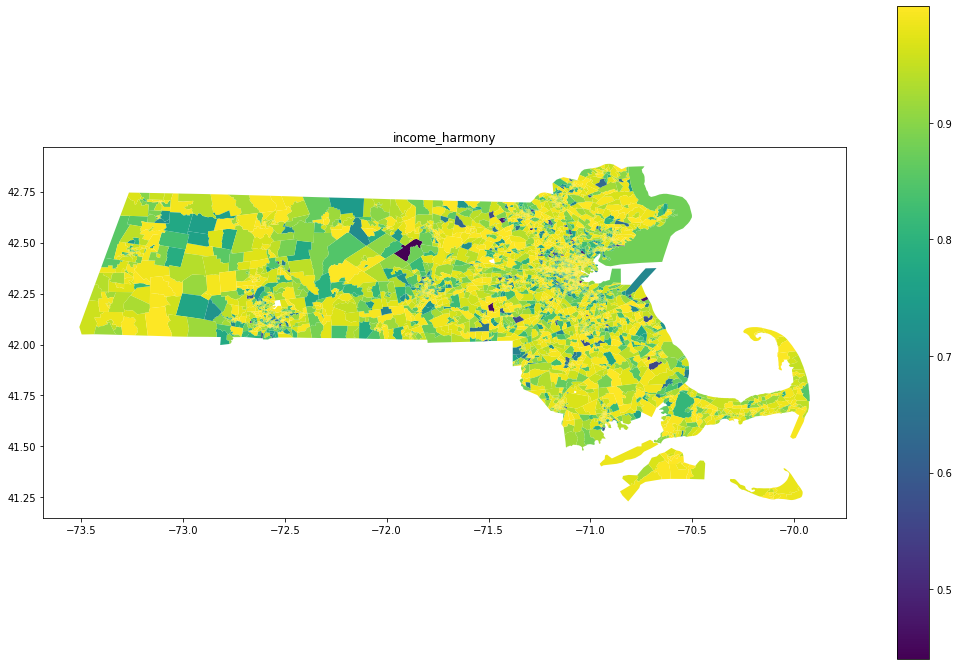

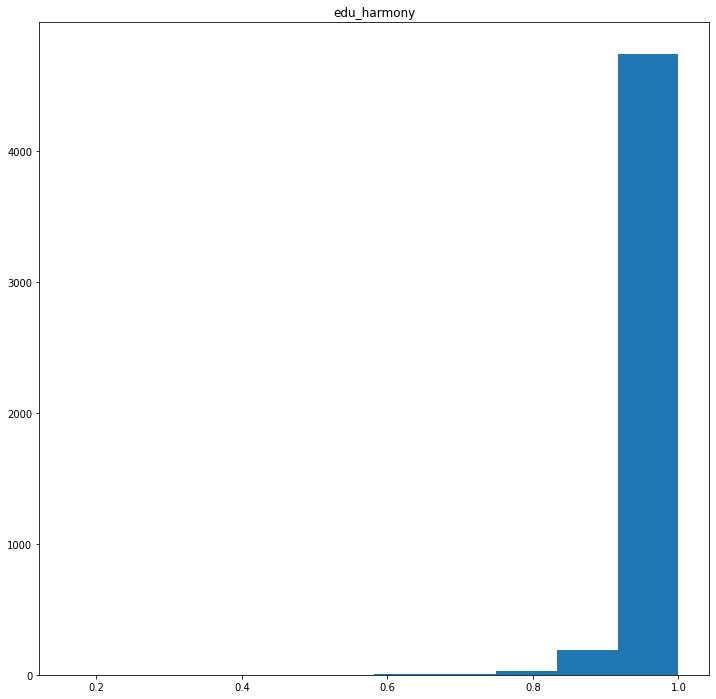

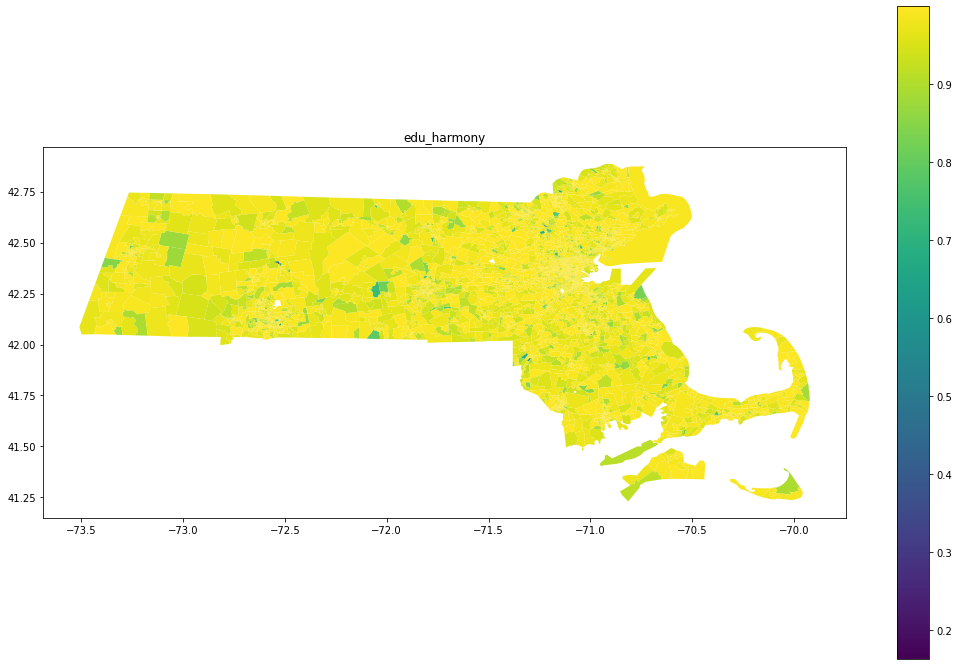

In [85]:
for col in ['income_harmony', 'edu_harmony']:
    plt.figure(figsize=(12,12))
    _=plt.hist(bg[col])
    plt.title(col)
    
    fig, ax=plt.subplots(1, figsize=(18,12))
    bg.plot(ax=ax,
            column=col,
            legend=True)
    ax.set_title(col)

### Access to Amenities Scores

In [33]:
def get_access_scores(row):
    output_dict={}
    row['healthcare_access']=row['emp_naics_62']
    row['hospitality_access']=row['emp_naics_72']
    row['shopping_access']=row['emp_naics_44-45']
    row['jobs_access']=row['total_employ_wac']
    return row

In [34]:
bg=bg.apply(lambda row: get_access_scores(row), axis=1)

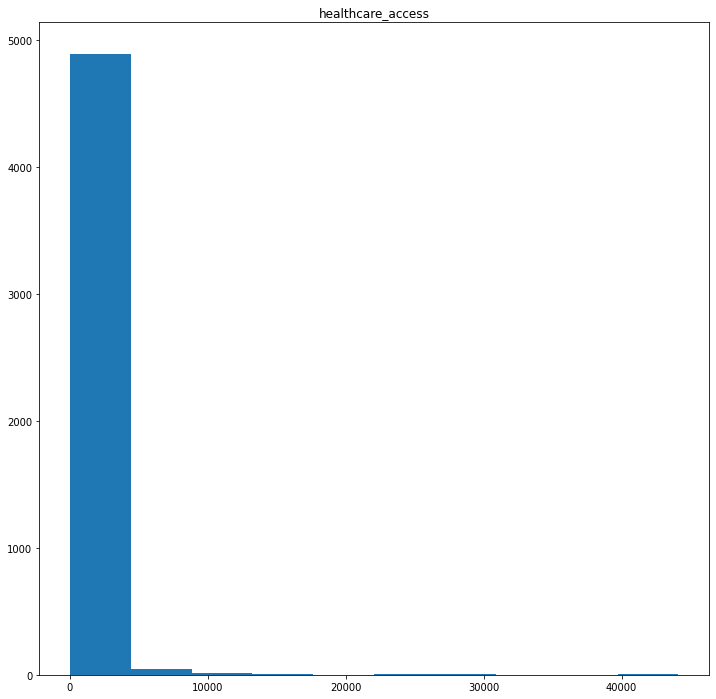

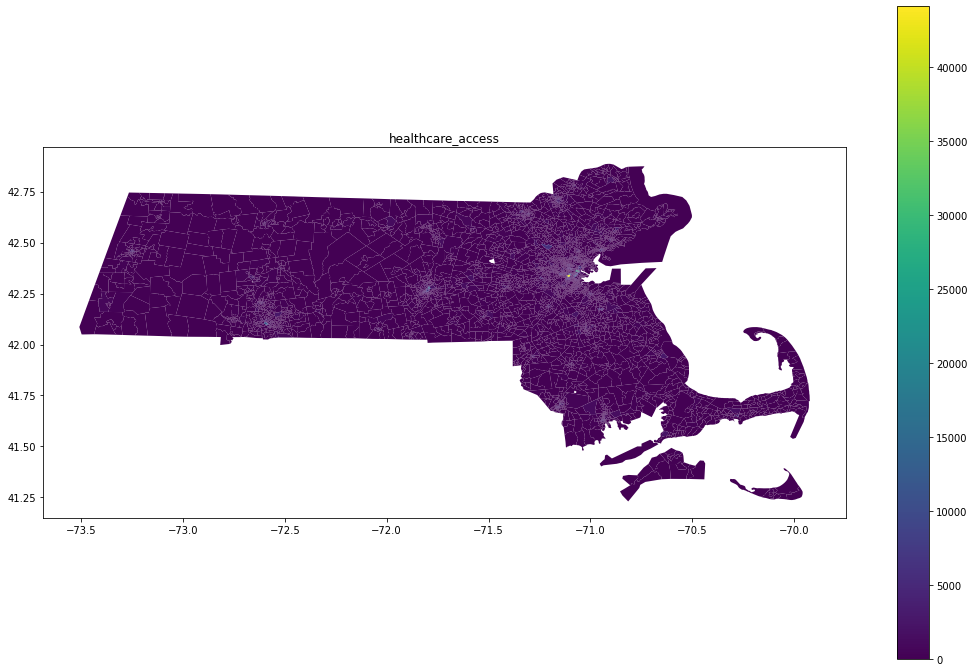

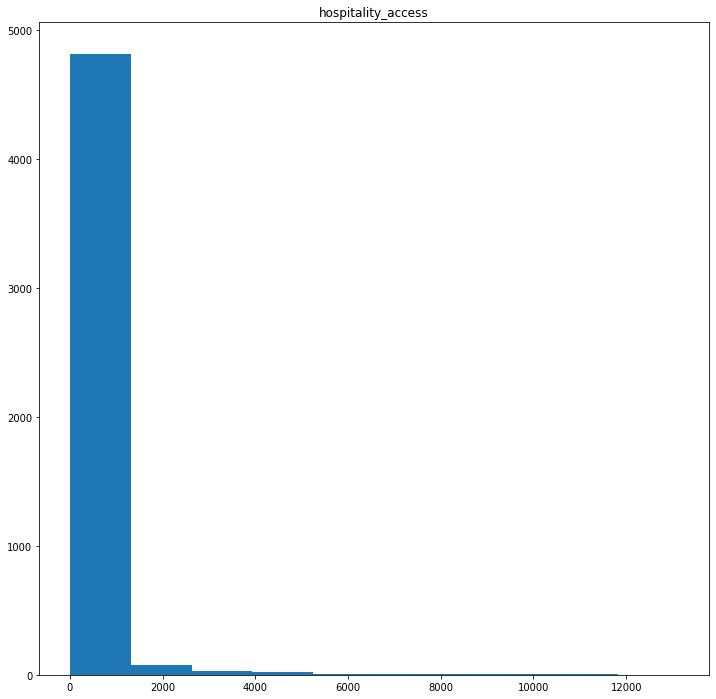

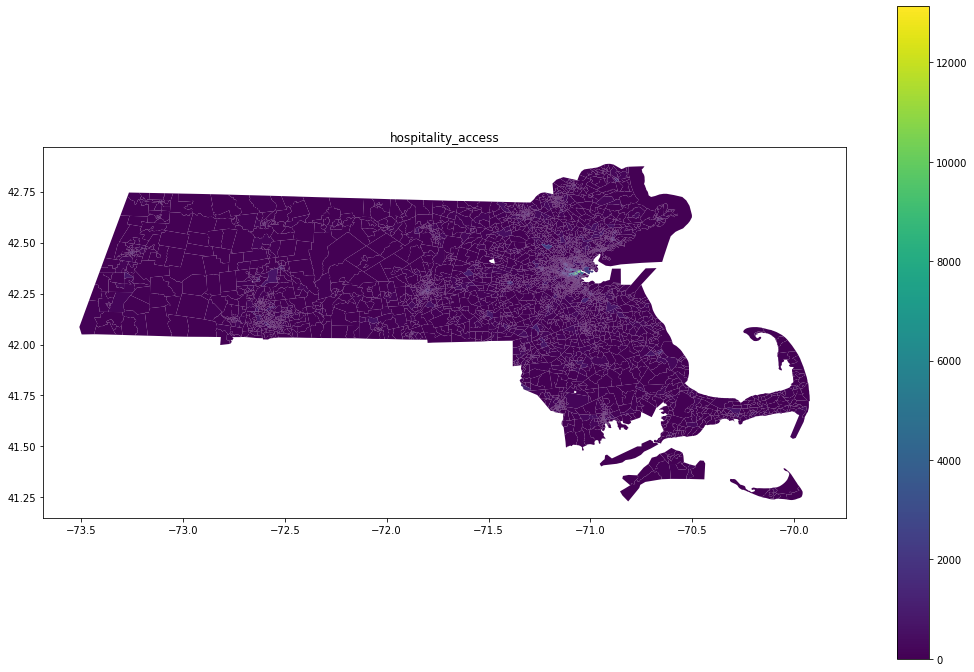

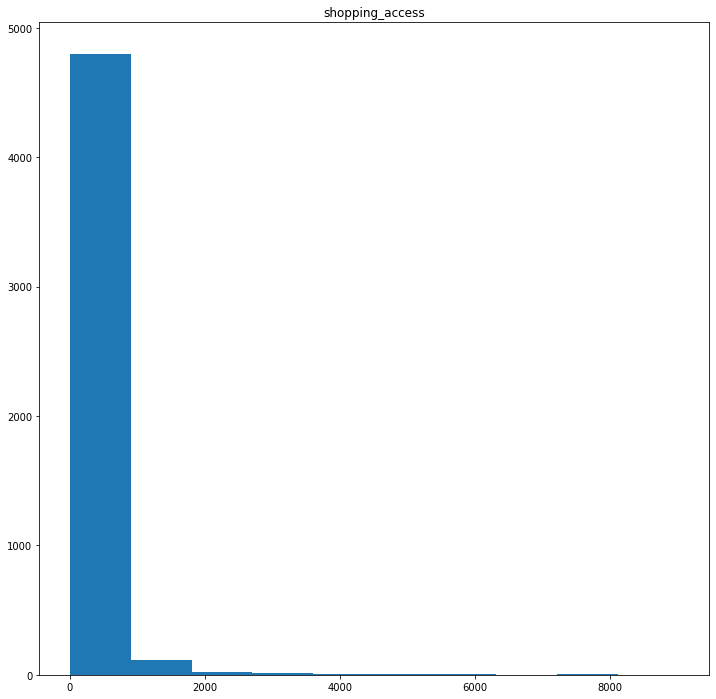

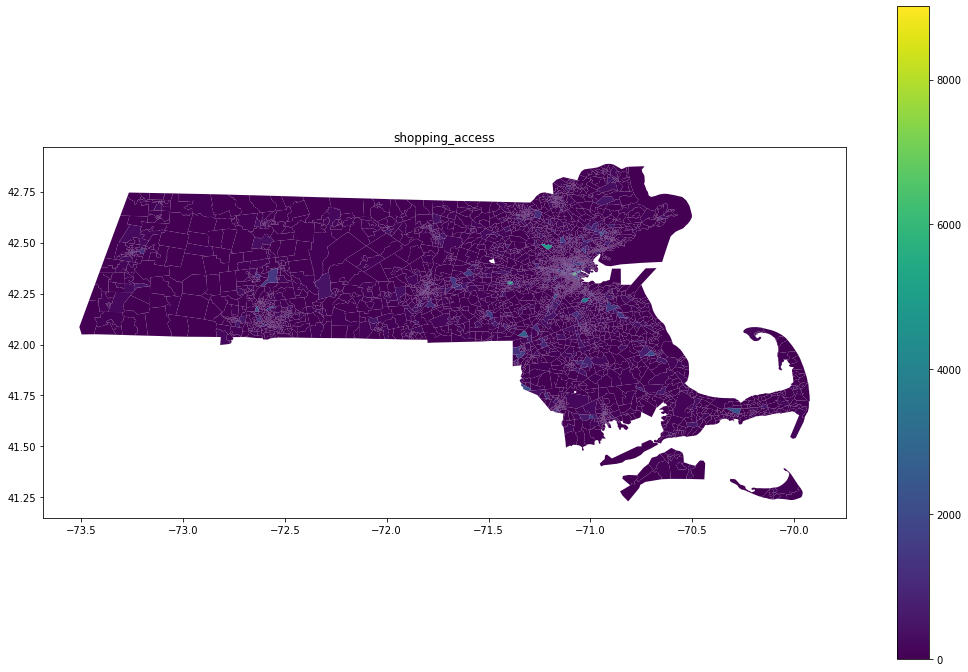

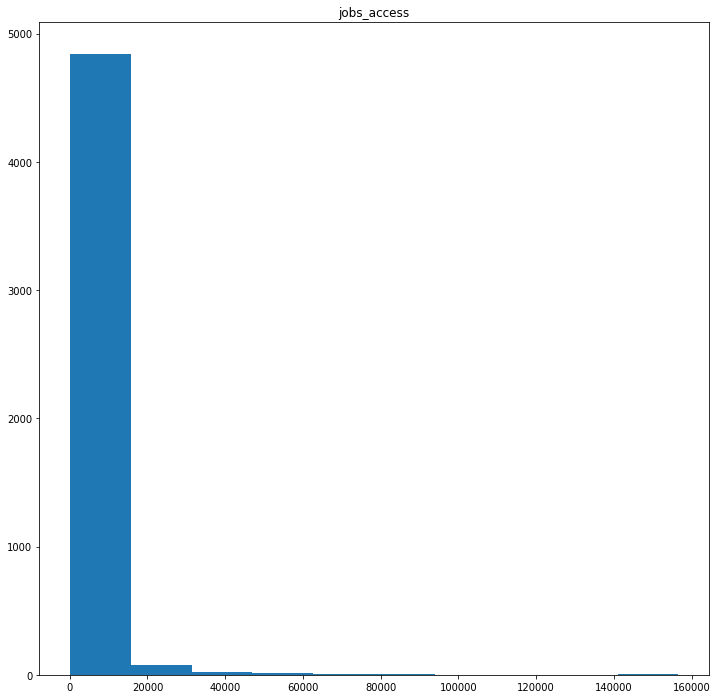

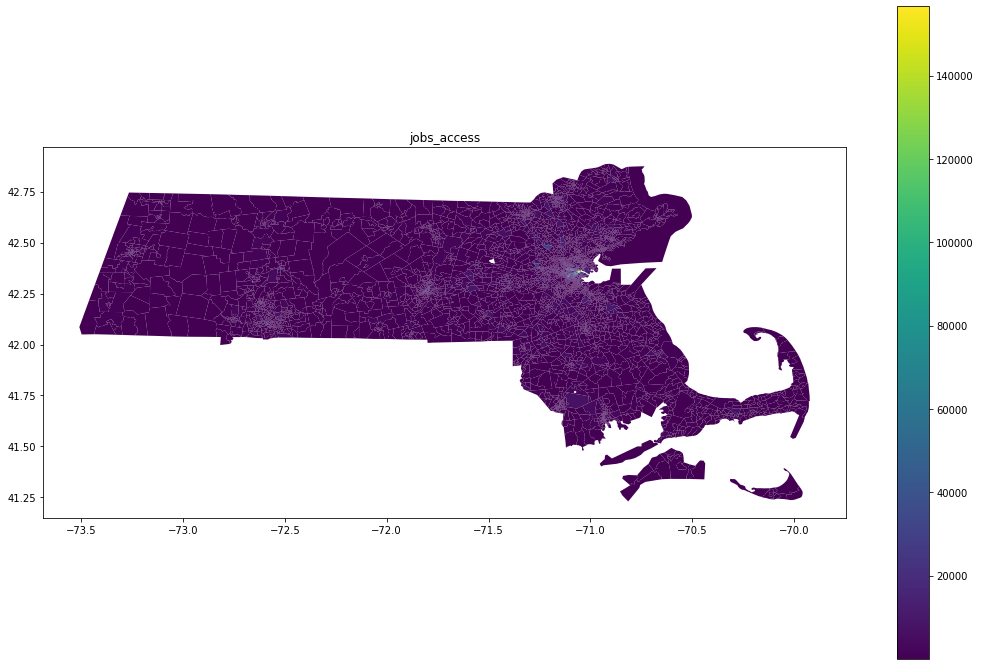

In [86]:
for col in ['healthcare_access', 'hospitality_access', 'shopping_access', 'jobs_access']:
    plt.figure(figsize=(12,12))
    _=plt.hist(bg[col])
    plt.title(col)
    
    fig, ax=plt.subplots(1, figsize=(18,12))
    bg.plot(ax=ax,
            column=col,
            legend=True)
    ax.set_title(col)

### Diversity Scores

In [73]:
import math
def shannon_equitability_score(species_counts):
    diversity=0
    pop_size=sum(species_counts)
    if ((len(species_counts)>1) and (pop_size>0)):        
        for count in species_counts:
            pj=count/pop_size
            if not pj==0:
                diversity+= -pj*math.log(pj)
        equitability=diversity/math.log(len(species_counts))
        return equitability
    else:
        return float('nan')
    
def get_diversity_scores(row):
    edu_group_cols=['res_edu_no_highsch', 'res_edu_highsch', 'res_edu_some_college', 'res_edu_bach_or_higher']
    income_group_cols=['res_income_1251-3333_rac', 'res_income_3333+_rac', 'res_income_u1250_rac']
    emp_group_cols=[col for col in row.keys() if 'emp_naics' in col]
    
    income_group_counts=[row[col] for col in income_group_cols]
    edu_group_counts=[row[col] for col in emp_group_cols]
    emp_group_counts=[row[col] for col in emp_group_cols]
    
    row['income_diversity']=shannon_equitability_score(income_group_counts)
    row['education_diversity']=shannon_equitability_score(edu_group_counts)
    row['employment_diversity']=shannon_equitability_score(emp_group_counts)
    return row
    

In [74]:
bg=bg.apply(lambda row: get_diversity_scores(row), axis=1)

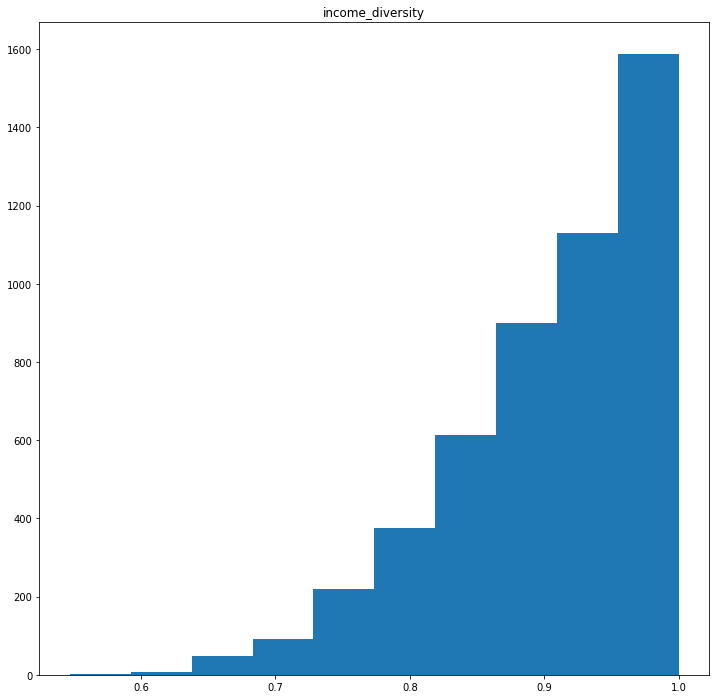

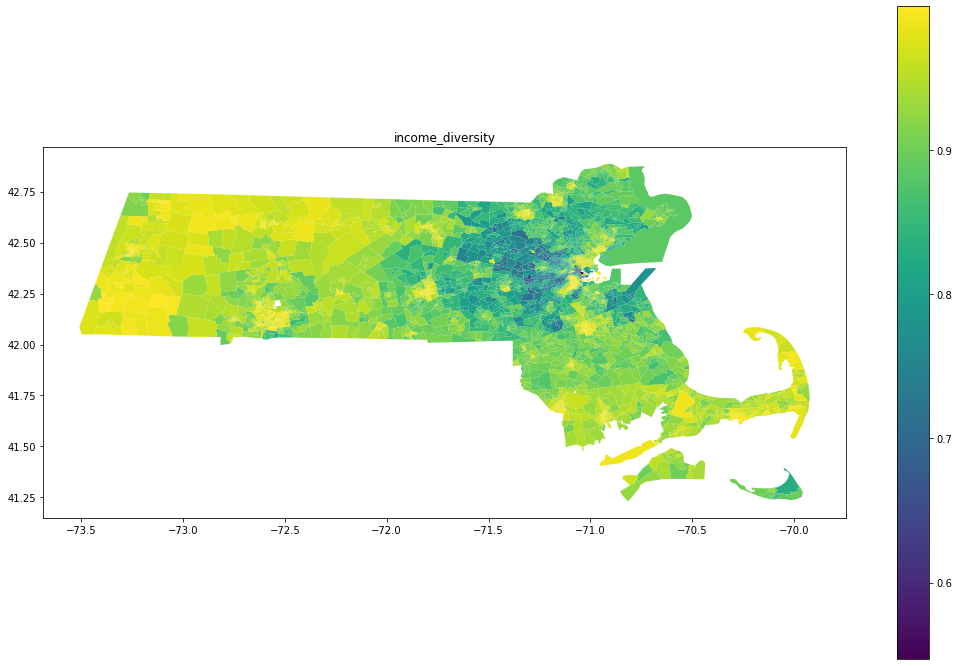

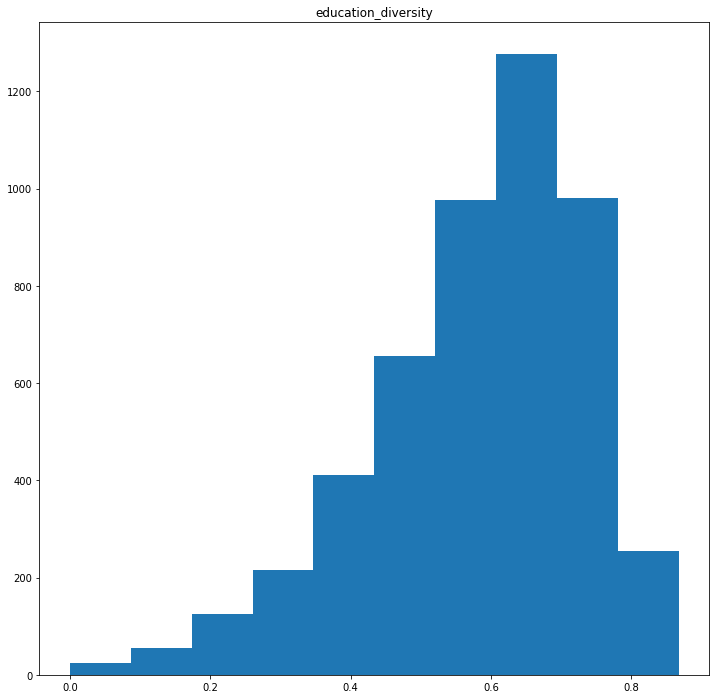

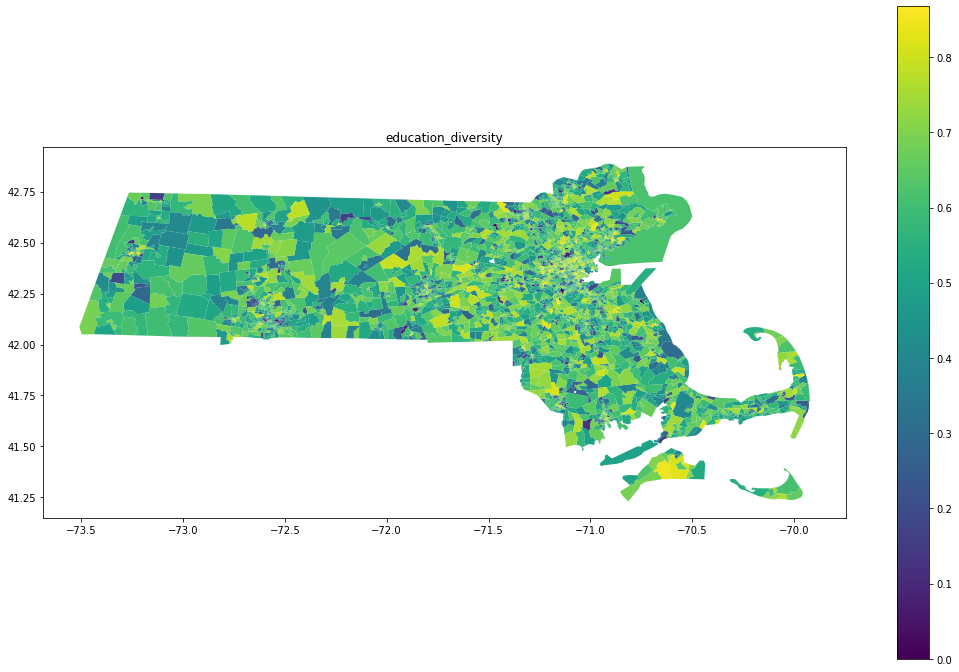

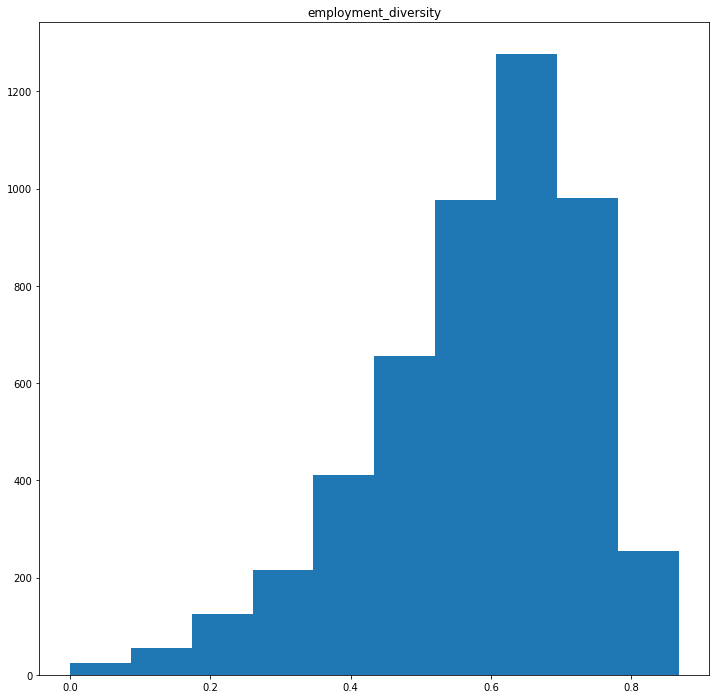

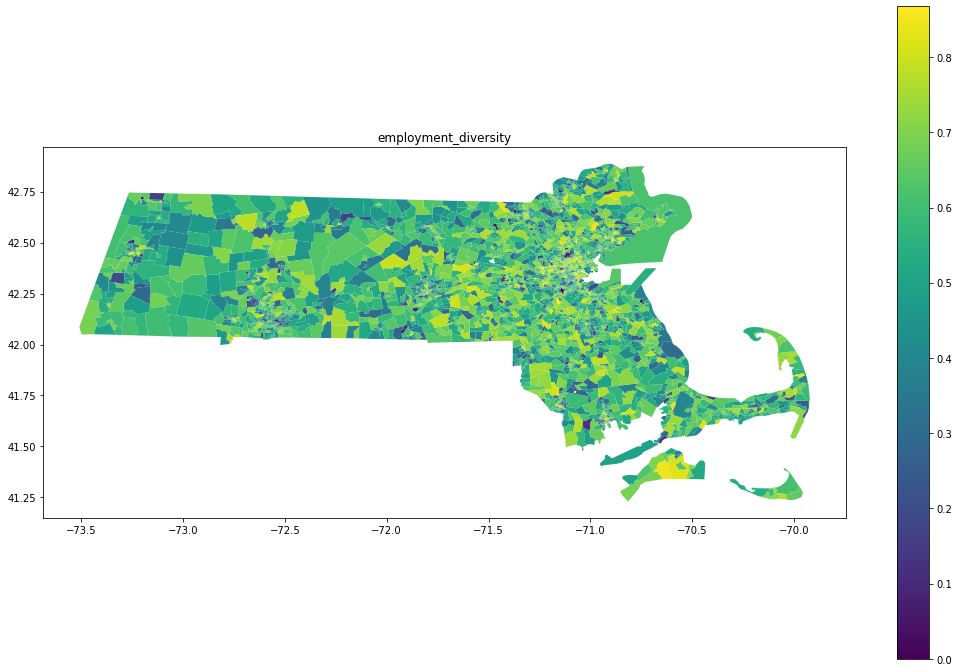

In [87]:
for col in ['income_diversity', 'education_diversity', 'employment_diversity']:
    plt.figure(figsize=(12,12))
    _=plt.hist(bg[col])
    plt.title(col)
    
    fig, ax=plt.subplots(1, figsize=(18,12))
    bg.plot(ax=ax,
            column=col,
            legend=True)
    ax.set_title(col)


# Raw Indicators -> Percentiles

In [76]:
import numpy as np
import statsmodels
from statsmodels.distributions.empirical_distribution import ECDF

In [77]:
score_groups={'Live-Work Symmetry':['live_work_score', 'income_harmony', 'edu_harmony'],
              'Local Services': ['healthcare_access','hospitality_access', 'shopping_access'],
              'Net-Zero Commuting': ['jobs_access'],
              'Diversity': ['income_diversity', 'education_diversity', 'employment_diversity']}
              

In [78]:
all_raw_score_cols=set()
for group in score_groups:
    all_raw_score_cols.update(score_groups[group])
print(all_raw_score_cols)

for col in all_raw_score_cols:
    ecdf=ECDF(bg[col])
    bg[col+'_pct']=ecdf(bg[col])
    bg.loc[bg[col].isnull(), col+'_pct']=float('nan')
    
for group in score_groups:
    pct_cols_this_group=['{}_pct'.format(col) for col in score_groups[group]]
    bg[group]=bg[pct_cols_this_group].mean(axis=1)

{'income_diversity', 'hospitality_access', 'shopping_access', 'edu_harmony', 'income_harmony', 'jobs_access', 'education_diversity', 'live_work_score', 'employment_diversity', 'healthcare_access'}


In [79]:
bg[[group for group in score_groups]]

Live-Work Symmetry  Local Services  Net-Zero Commuting  Diversity
0               0.025075        0.222601            0.036911   0.251421
1               0.399666        0.636978            0.391174   0.440722
2               0.031695        0.110532            0.002808   0.112270
3               0.347777        0.283250            0.420261   0.189435
4               0.225677        0.258375            0.145236   0.466466
...                  ...             ...                 ...        ...
4980            0.856503        0.775527            0.780943   0.900769
4981            0.267536        0.179873            0.101103   0.256436
4982            0.583551        0.271414            0.356269   0.461184
4983            0.438315        0.692745            0.658175   0.700234
4984            0.216182        0.151655            0.332397   0.181678

[4985 rows x 4 columns]

# Final Individual Scores

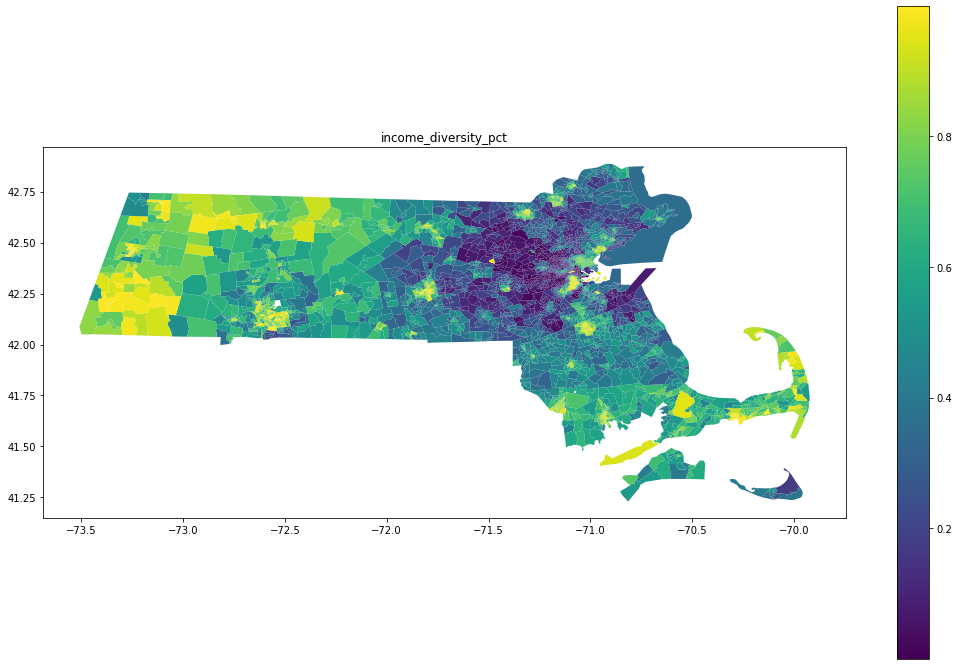

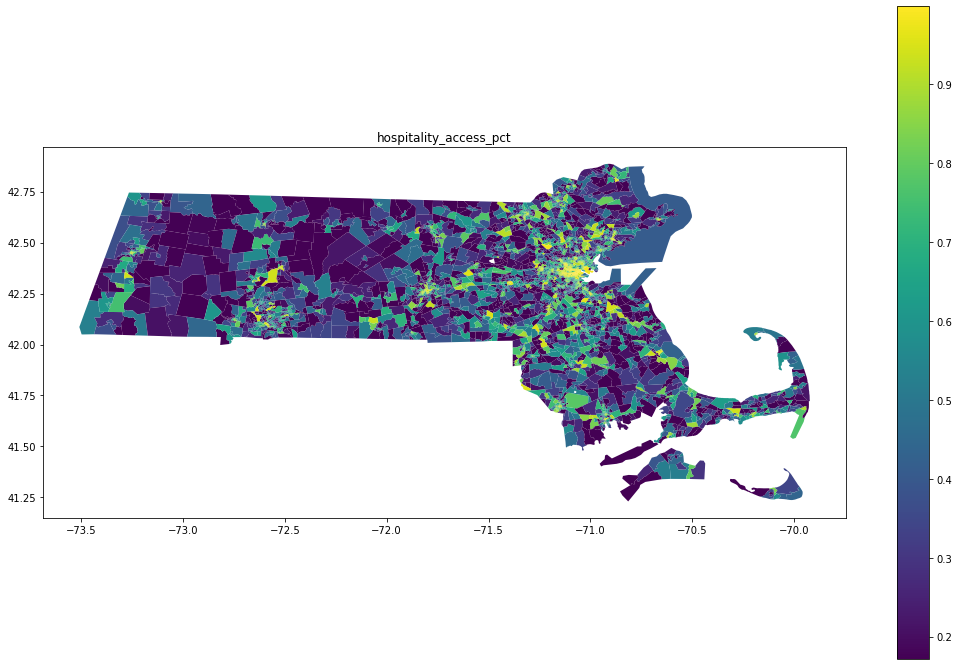

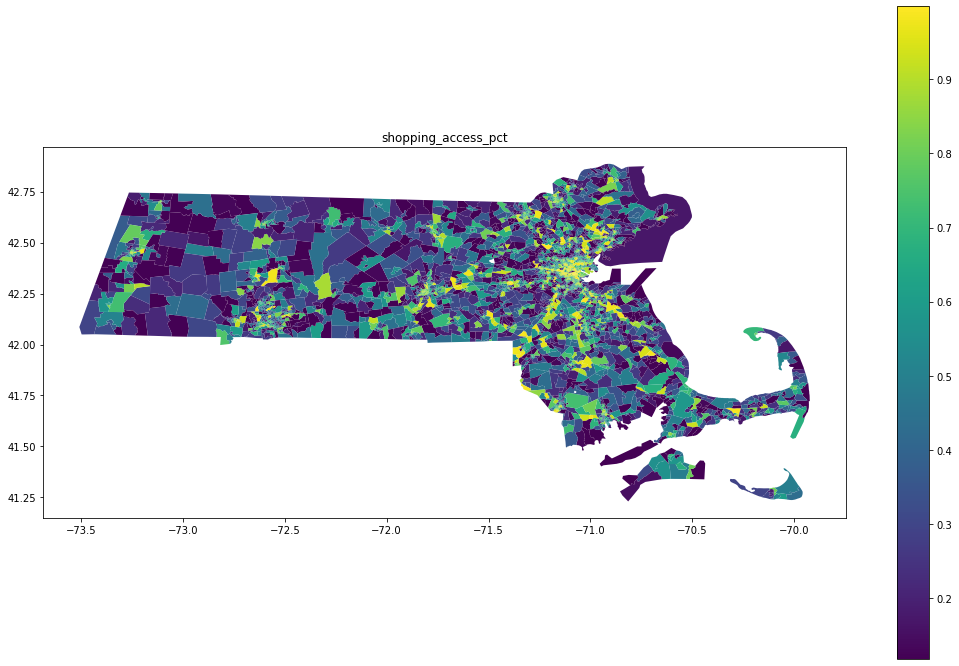

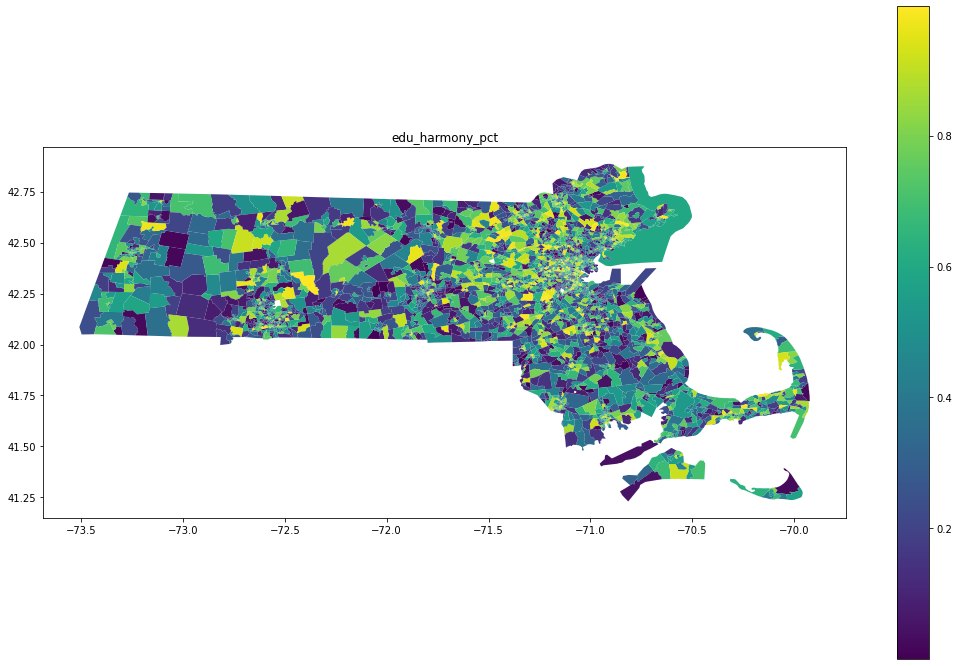

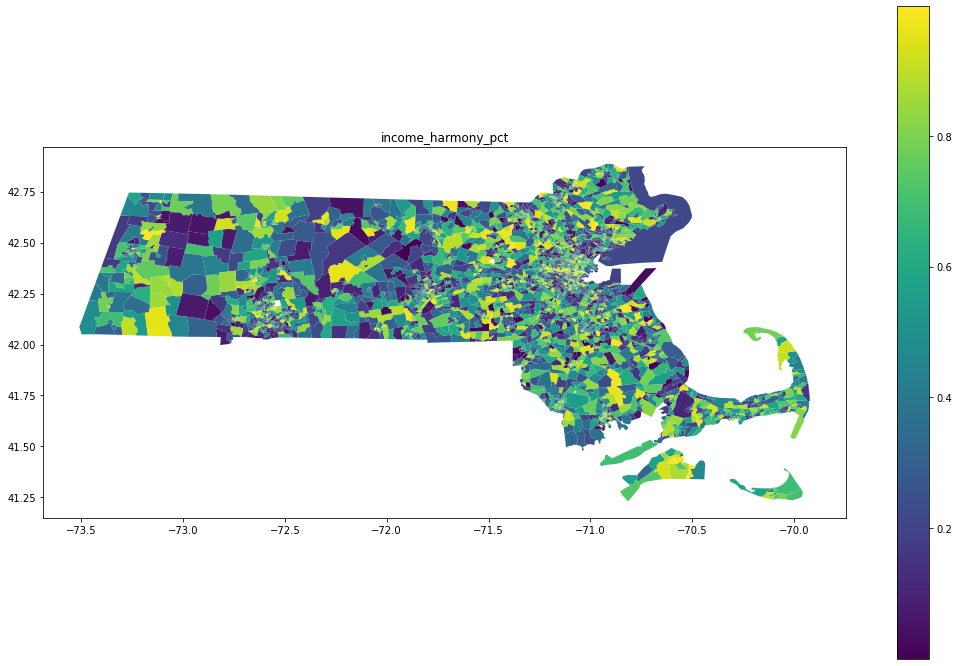

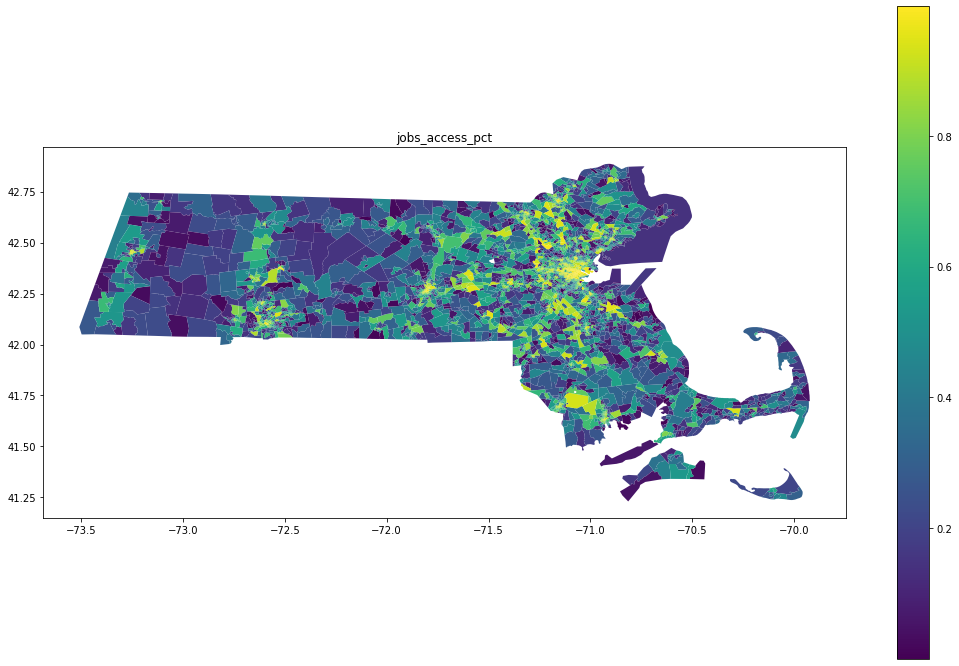

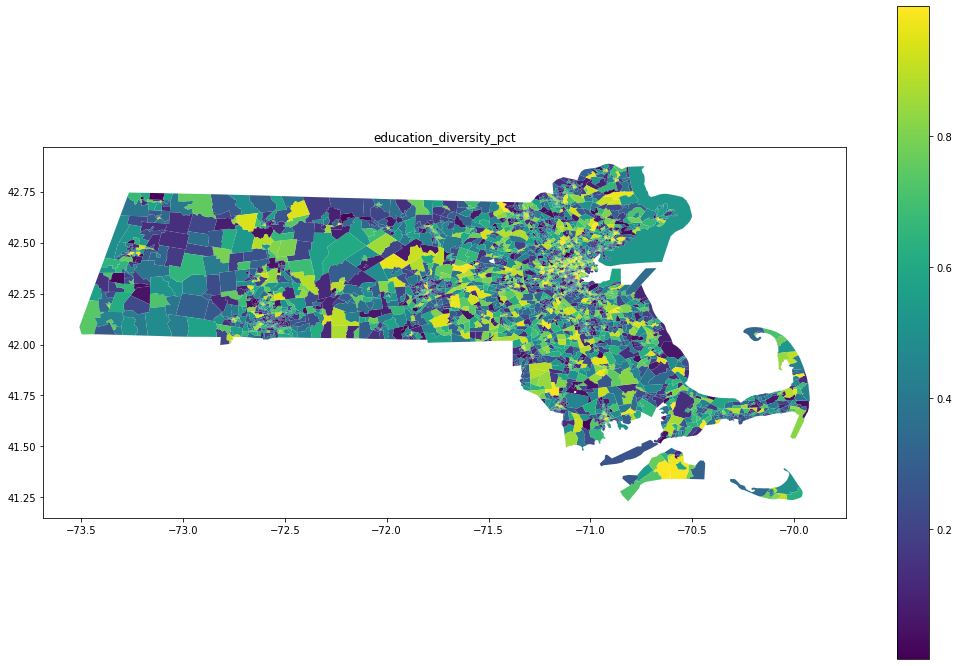

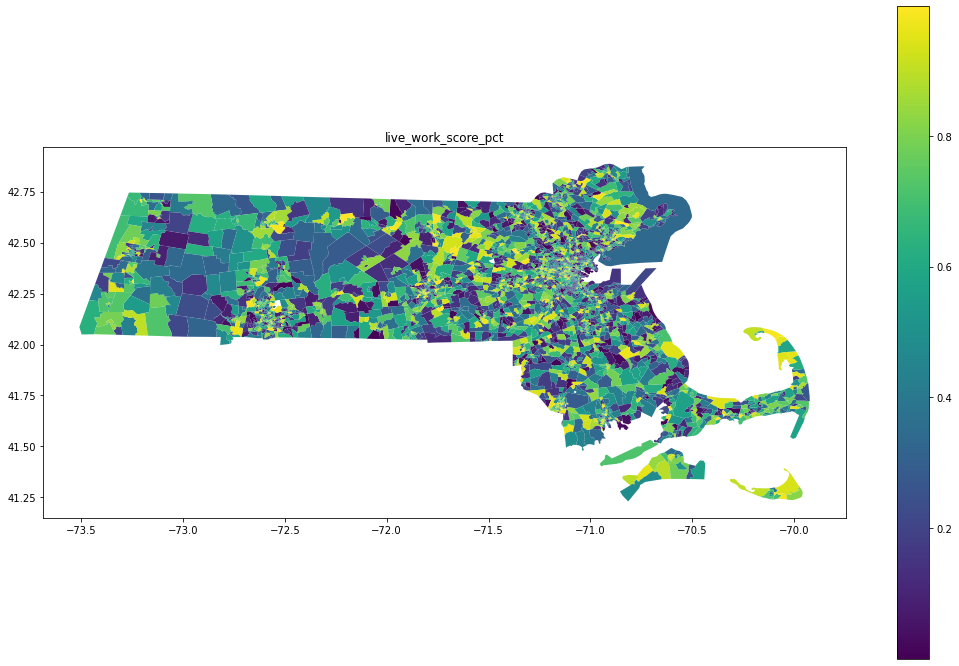

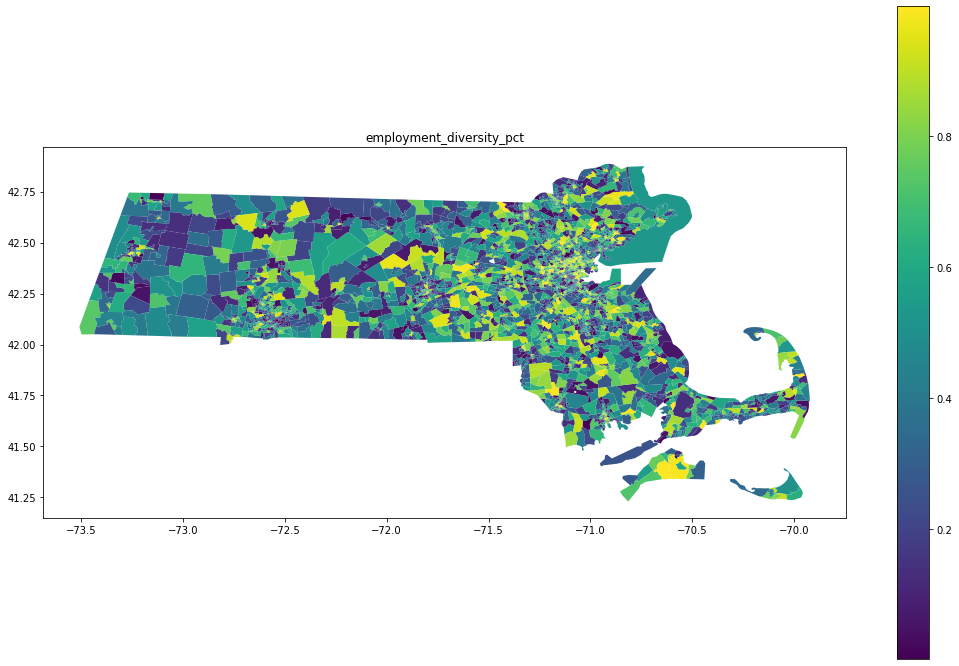

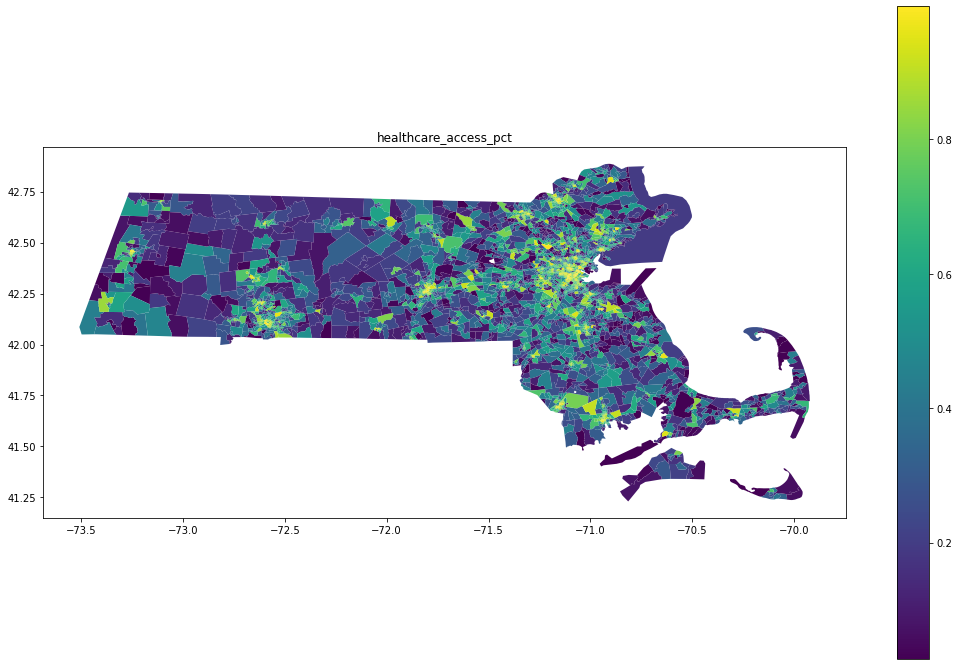

In [88]:
for score in all_raw_score_cols:
    col=score+'_pct'
    fig, ax=plt.subplots(1, figsize=(18,12))
    bg.plot(ax=ax,
            column=col,
            legend=True)
    ax.set_title(col)

# Final Grouped Scores

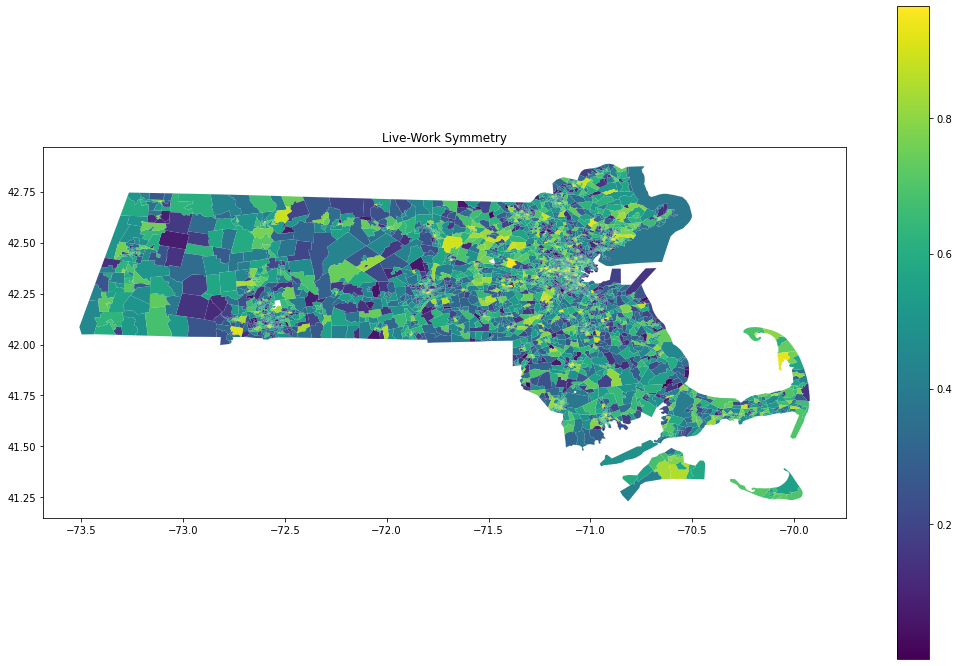

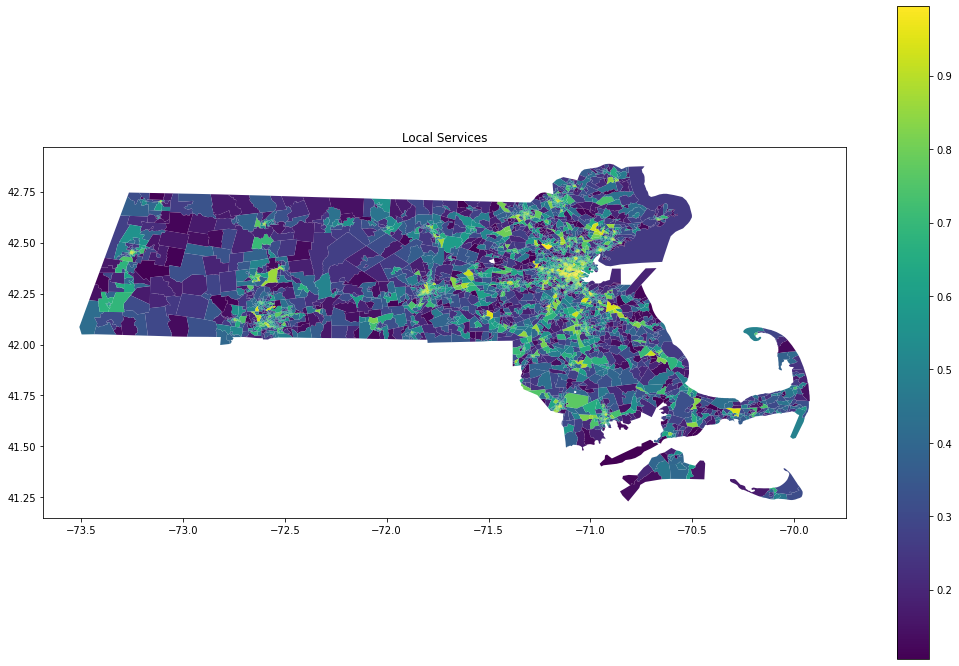

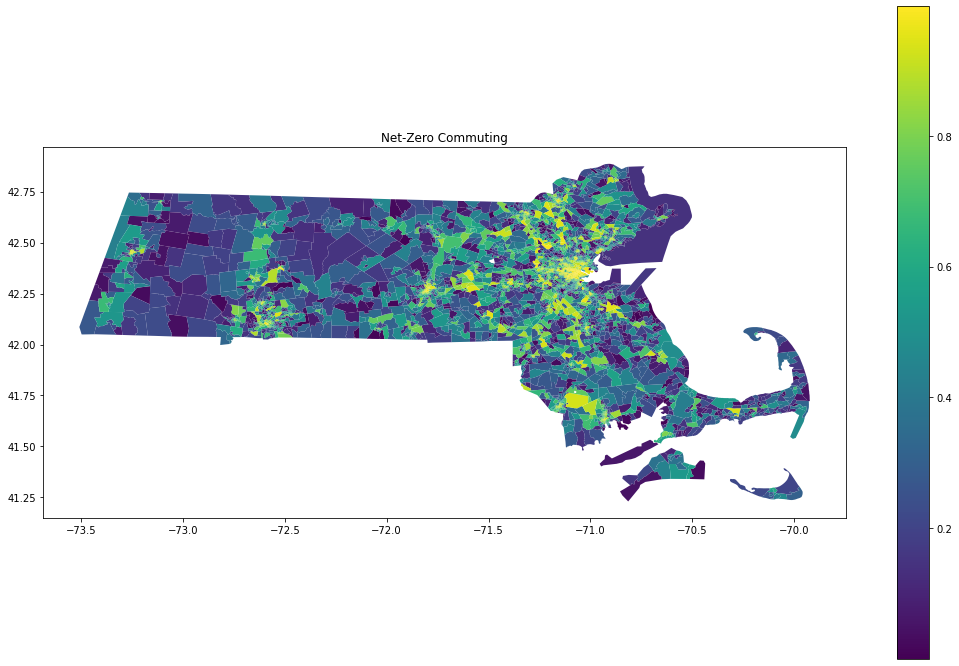

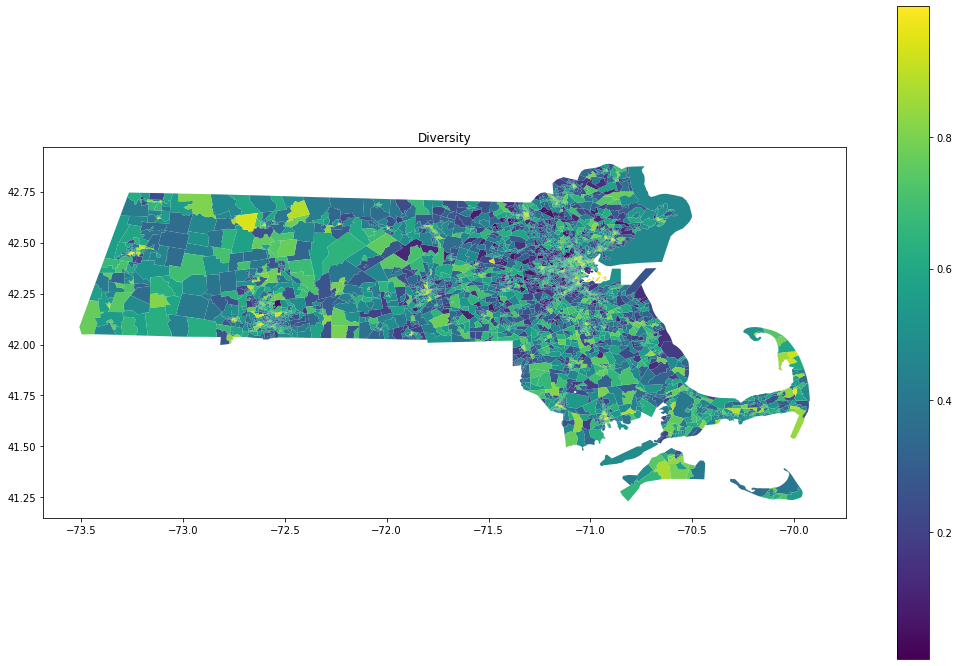

In [80]:
for group in score_groups:
    fig, ax=plt.subplots(1, figsize=(18,12))
    bg.plot(ax=ax,
            column=group,
            legend=True)
    ax.set_title(group)

In [93]:
all_final_scores= [sg for sg in score_groups] + [score+'_pct' for score in all_raw_score_cols]

In [102]:
save_cols=['GEOID','geometry']+all_final_scores
bg[save_cols].to_file('../outputs/metrics/metrics_{}/metrics_{}.shp'.format(state_fips, state_fips))